A Step by Step Example of Back Propagation

https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example

In [229]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import copy

In [230]:
class NeuralNetwork:
    LEARNING_RATE = 0.5

    def __init__(self, num_inputs, num_hidden, num_outputs, hidden_layer_weights = None, hidden_layer_bias = None, output_layer_weights = None, output_layer_bias = None):
        self.num_inputs = num_inputs

        self.hidden_layer = NeuronLayer(num_hidden, hidden_layer_bias)
        self.output_layer = NeuronLayer(num_outputs, output_layer_bias)

        self.init_weights_from_inputs_to_hidden_layer_neurons(hidden_layer_weights)
        self.init_weights_from_hidden_layer_neurons_to_output_layer_neurons(output_layer_weights)

    def init_weights_from_inputs_to_hidden_layer_neurons(self, hidden_layer_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_weights:
                    self.hidden_layer.neurons[h].weights.append(random.random())
                else:
                    self.hidden_layer.neurons[h].weights.append(hidden_layer_weights[weight_num])
                weight_num += 1

    def init_weights_from_hidden_layer_neurons_to_output_layer_neurons(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(random.random())
                else:
                    self.output_layer.neurons[o].weights.append(output_layer_weights[weight_num])
                weight_num += 1

    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer')
        self.hidden_layer.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')

    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs)
        return self.output_layer.feed_forward(hidden_layer_outputs)

    # Uses online learning, ie updating the weights after each training case
    def train(self, training_inputs, training_outputs):
        self.feed_forward(training_inputs)

        # 1. Output neuron deltas
        pd_errors_wrt_output_neuron_total_net_input = [0] * len(self.output_layer.neurons)
        for o in range(len(self.output_layer.neurons)):

            # ∂E/∂zⱼ
            # In the text, it calculates ∂E_total/∂net_net_o1
            pd_errors_wrt_output_neuron_total_net_input[o] = self.output_layer.neurons[o].calculate_pd_error_wrt_total_net_input(training_outputs[o])

        # 2. Hidden neuron deltas
        pd_errors_wrt_hidden_neuron_total_net_input = [0] * len(self.hidden_layer.neurons)
        for h in range(len(self.hidden_layer.neurons)):

            # We need to calculate the derivative of the error with respect to the output of each hidden layer neuron
            # dE/dyⱼ = Σ ∂E/∂zⱼ * ∂z/∂yⱼ = Σ ∂E/∂zⱼ * wᵢⱼ
            d_error_wrt_hidden_neuron_output = 0
            for o in range(len(self.output_layer.neurons)):
                d_error_wrt_hidden_neuron_output += pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].weights[h]

            # ∂E/∂zⱼ = dE/dyⱼ * ∂zⱼ/∂
            pd_errors_wrt_hidden_neuron_total_net_input[h] = d_error_wrt_hidden_neuron_output * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_input()

        # 3. Update output neuron weights
        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):

                # ∂Eⱼ/∂wᵢⱼ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢⱼ
                pd_error_wrt_weight = pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].calculate_pd_total_net_input_wrt_weight(w_ho)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.output_layer.neurons[o].weights[w_ho] -= self.LEARNING_RATE * pd_error_wrt_weight

        # 4. Update hidden neuron weights
        for h in range(len(self.hidden_layer.neurons)):
            for w_ih in range(len(self.hidden_layer.neurons[h].weights)):

                # ∂Eⱼ/∂wᵢ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢ
                pd_error_wrt_weight = pd_errors_wrt_hidden_neuron_total_net_input[h] * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_weight(w_ih)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.hidden_layer.neurons[h].weights[w_ih] -= self.LEARNING_RATE * pd_error_wrt_weight

    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].calculate_error(training_outputs[o])
        return total_error

class NeuronLayer:
    def __init__(self, num_neurons, bias):

        # Every neuron in a layer shares the same bias
        self.bias = bias if bias else random.random()

        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

class Neuron:
    def __init__(self, bias):
        self.bias = bias
        self.weights = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    # Apply the logistic (activation) function to squash the output of the neuron
    # The result is sometimes referred to as 'net' [2] or 'net' [1]
    def squash(self, total_net_input):
        return 1 / (1 + math.exp(-total_net_input))

    # Determine how much the neuron's total input has to change to move closer to the expected output
    #
    # Now that we have the partial derivative of the error with respect to the output (∂E/∂yⱼ) and
    # the derivative of the output with respect to the total net input (dyⱼ/dzⱼ) we can calculate
    # the partial derivative of the error with respect to the total net input.
    # This value is also known as the delta (δ) [1]
    # δ = ∂E/∂zⱼ = ∂E/∂yⱼ * dyⱼ/dzⱼ
    #
    def calculate_pd_error_wrt_total_net_input(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.calculate_pd_total_net_input_wrt_input();

    # The error for each neuron is calculated by the Mean Square Error method:
    def calculate_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    # The partial derivate of the error with respect to actual output then is calculated by:
    # = 2 * 0.5 * (target output - actual output) ^ (2 - 1) * -1
    # = -(target output - actual output)
    #
    # The Wikipedia article on backpropagation [1] simplifies to the following, but most other learning material does not [2]
    # = actual output - target output
    #
    # Alternative, you can use (target - output), but then need to add it during backpropagation [3]
    #
    # Note that the actual output of the output neuron is often written as yⱼ and target output as tⱼ so:
    # = ∂E/∂yⱼ = -(tⱼ - yⱼ)
    def calculate_pd_error_wrt_output(self, target_output):
        return -(target_output - self.output)

    # The total net input into the neuron is squashed using logistic function to calculate the neuron's output:
    # yⱼ = φ = 1 / (1 + e^(-zⱼ))
    # Note that where ⱼ represents the output of the neurons in whatever layer we're looking at and ᵢ represents the layer below it
    #
    # The derivative (not partial derivative since there is only one variable) of the output then is:
    # dyⱼ/dzⱼ = yⱼ * (1 - yⱼ)
    def calculate_pd_total_net_input_wrt_input(self):
        return self.output * (1 - self.output)

    # The total net input is the weighted sum of all the inputs to the neuron and their respective weights:
    # = zⱼ = netⱼ = x₁w₁ + x₂w₂ ...
    #
    # The partial derivative of the total net input with respective to a given weight (with everything else held constant) then is:
    # = ∂zⱼ/∂wᵢ = some constant + 1 * xᵢw₁^(1-0) + some constant ... = xᵢ
    def calculate_pd_total_net_input_wrt_weight(self, index):
        return self.inputs[index]

###

In [231]:
nn = NeuralNetwork(2, 2, 2, hidden_layer_weights=[0.15, 0.2, 0.25, 0.3], hidden_layer_bias=0.35, output_layer_weights=[0.4, 0.45, 0.5, 0.55], output_layer_bias=0.6)

num_hidden_layer = 2
num_output_layer = 2

index = []
hidden_layer_neuron_weights = []
hidden_layer_neuron_bias = []
output_layer_neuron_weights = []
output_layer_neuron_bias = []
total_errors = []

for i in range(1000):
    nn.train([0.05, 0.1], [0.01, 0.99]) # train(training_inputs, training_outputs)
    #print(i, round(nn.calculate_total_error([[[0.05, 0.1], [0.01, 0.99]]]), 9)) # calculate_total_error(training_sets)
    #print(i, [nn.hidden_layer.neurons[x].bias for x in range(num_hidden_layer)])
    hnw = copy.deepcopy([nn.hidden_layer.neurons[x].weights for x in range(num_hidden_layer)])
    hnb = copy.deepcopy([nn.hidden_layer.neurons[x].bias for x in range(num_hidden_layer)])
    onw = copy.deepcopy([nn.output_layer.neurons[x].weights for x in range(num_output_layer)])
    onb = copy.deepcopy([nn.output_layer.neurons[x].bias for x in range(num_output_layer)])
    index.append(i)
    hidden_layer_neuron_weights.append(hnw)
    hidden_layer_neuron_bias.append(hnb)
    output_layer_neuron_weights.append(onw)
    output_layer_neuron_bias.append(onb)
    total_errors.append(round(nn.calculate_total_error([[[0.05, 0.1], [0.01, 0.99]]]), 9))

In [236]:
hidden_layer_neuron_weights = np.array(hidden_layer_neuron_weights)
hidden_layer_neuron_bias = np.array(hidden_layer_neuron_bias)
output_layer_neuron_weights = np.array(output_layer_neuron_weights)
output_layer_neuron_bias = np.array(output_layer_neuron_bias)


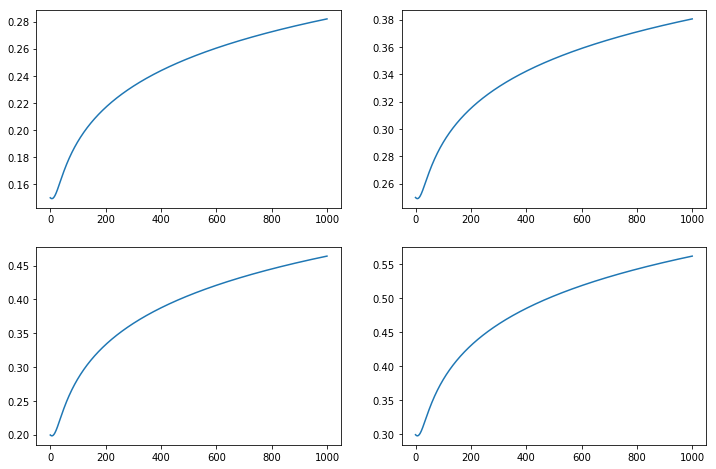

In [233]:
# Visualization
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0,0].plot(index, hidden_layer_neuron_weights[:,0,0])
ax[0,1].plot(index, hidden_layer_neuron_weights[:,1,0])
ax[1,0].plot(index, hidden_layer_neuron_weights[:,0,1])
ax[1,1].plot(index, hidden_layer_neuron_weights[:,1,1])

2.110885730396752 2.0517051904569836


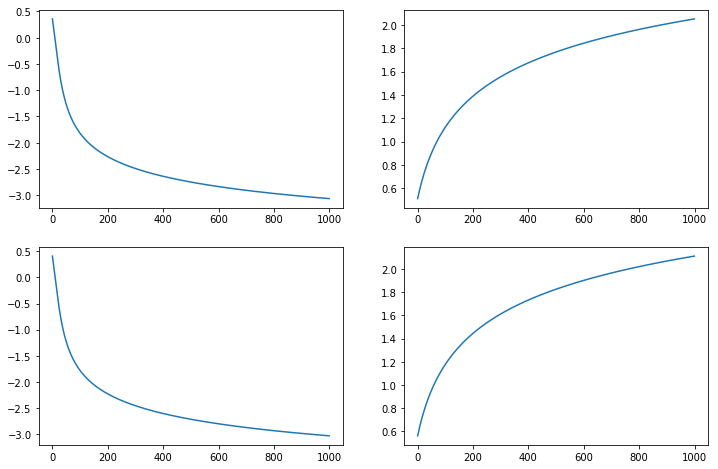

In [239]:
# Visualization
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0,0].plot(index, output_layer_neuron_weights[:,0,0])
ax[0,1].plot(index, output_layer_neuron_weights[:,1,0])
ax[1,0].plot(index, output_layer_neuron_weights[:,0,1])
ax[1,1].plot(index, output_layer_neuron_weights[:,1,1])
print(output_layer_neuron_weights[-1,1,1],output_layer_neuron_weights[-1,1,0])

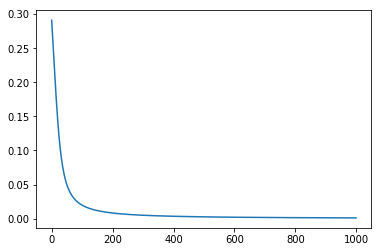

In [235]:
fig, ax = plt.subplots(1, figsize=(6,4))
ax.plot(index, total_errors)